<a href="https://colab.research.google.com/github/Dipeshtamboli/Interactive-GradCAM/blob/master/Interactive_GradCAM_COCO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch.nn as nn
import os
import torch.nn.functional as F
import pdb
# from net_contrast import VGG16Backbone, Decoder, FC_HEAD
import argparse
import cv2
import numpy as np
import torch
from torch.autograd import Function
from torchvision import models

class ModelOutputs():
    def __init__(self, model, feature_module, target_layers):
        self.model = model
        self.feature_module = feature_module
        self.feature_extractor = FeatureExtractor(self.feature_module, target_layers)

    def get_gradients(self):
        return self.feature_extractor.gradients

    def __call__(self, x):
        target_activations = []
        for name, module in self.model._modules.items():
            if module == self.feature_module:
                target_activations, x = self.feature_extractor(x)
            elif "conv" in name.lower():
                x = module(x)
                x = F.max_pool2d(x, kernel_size=x.size()[2:])
                x = x.view(x.size(0),-1)
            else:
                x = module(x)
        return target_activations, x


def preprocess_image(img):
    means = [0.485, 0.456, 0.406]
    stds = [0.229, 0.224, 0.225]

    preprocessed_img = img.copy()[:, :, ::-1]
    for i in range(3):
        preprocessed_img[:, :, i] = preprocessed_img[:, :, i] - means[i]
        preprocessed_img[:, :, i] = preprocessed_img[:, :, i] / stds[i]
    preprocessed_img = \
        np.ascontiguousarray(np.transpose(preprocessed_img, (2, 0, 1)))
    preprocessed_img = torch.from_numpy(preprocessed_img)
    preprocessed_img.unsqueeze_(0)
    input = preprocessed_img.requires_grad_(True)
    return input

def create_dir(path_to_img):
    directory = os.path.join(*path_to_img.split('/')[:-1]) 
    if not os.path.exists(directory):
        os.makedirs(directory)    

def save_img(image_path, img, if_range_0_1=False):
    create_dir(image_path)
    if if_range_0_1:
        cv2.imwrite(image_path, np.uint8(255 * img))
    else:
        cv2.imwrite(image_path, (img))

def show_cam_on_image(img, mask, img_path):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    # cv2.imwrite("cam.jpg", np.uint8(255 * cam))
    # save_img(img_path,cam,if_range_0_1=True)
    return np.uint8(255 * cam)


class GradCam:
    def __init__(self, model, feature_module, target_layer_names, use_cuda):
        self.model = model
        self.feature_module = feature_module
        self.model.eval()
        self.cuda = use_cuda
        if self.cuda:
            self.model = model.cuda()

        self.extractor = ModelOutputs(self.model, self.feature_module, target_layer_names)

    def forward(self, input):
        return self.model(input)

    def __call__(self, input, index=None):
        if self.cuda:
            features, output = self.extractor(input.cuda())
        else:
            features, output = self.extractor(input)

        if index == None:
            index = np.argmax(output.cpu().data.numpy())

        one_hot = np.zeros((1, output.size()[-1]), dtype=np.float32)
        one_hot[0][index] = 1
        one_hot = torch.from_numpy(one_hot).requires_grad_(True)
        if self.cuda:
            one_hot = torch.sum(one_hot.cuda() * output)
        else:
            one_hot = torch.sum(one_hot * output)

        self.feature_module.zero_grad()
        self.model.zero_grad()
        one_hot.backward(retain_graph=True)

        grads_val = self.extractor.get_gradients()[-1].cpu().data.numpy()

        target = features[-1]
        target = target.cpu().data.numpy()[0, :]

        weights = np.mean(grads_val, axis=(2, 3))[0, :]
        cam = np.zeros(target.shape[1:], dtype=np.float32)

        for i, w in enumerate(weights):
            cam += w * target[i, :, :]

        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, input.shape[2:])
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)
        return cam


class GuidedBackpropReLU(Function):

    @staticmethod
    def forward(self, input):
        positive_mask = (input > 0).type_as(input)
        output = torch.addcmul(torch.zeros(input.size()).type_as(input), input, positive_mask)
        self.save_for_backward(input, output)
        return output

    @staticmethod
    def backward(self, grad_output):
        input, output = self.saved_tensors
        grad_input = None

        positive_mask_1 = (input > 0).type_as(grad_output)
        positive_mask_2 = (grad_output > 0).type_as(grad_output)
        grad_input = torch.addcmul(torch.zeros(input.size()).type_as(input),
                                   torch.addcmul(torch.zeros(input.size()).type_as(input), grad_output,
                                                 positive_mask_1), positive_mask_2)

        return grad_input


class GuidedBackpropReLUModel:
    def __init__(self, model, use_cuda):
        self.model = model
        self.model.eval()
        self.cuda = use_cuda
        if self.cuda:
            self.model = model.cuda()

        def recursive_relu_apply(module_top):
            for idx, module in module_top._modules.items():
                recursive_relu_apply(module)
                if module.__class__.__name__ == 'ReLU':
                    module_top._modules[idx] = GuidedBackpropReLU.apply
                
        # replace ReLU with GuidedBackpropReLU
        recursive_relu_apply(self.model)

    def forward(self, input):
        return self.model(input)

    def __call__(self, input, index=None):
        if self.cuda:
            output = self.forward(input.cuda())
        else:
            output = self.forward(input)

        output = output[0]
        if index == None:
            # pdb.set_trace()
            index = np.argmax(output.cpu().data.numpy())

        one_hot = np.zeros((1, output.size()[-1]), dtype=np.float32)
        one_hot[0][index] = 1
        one_hot = torch.from_numpy(one_hot).requires_grad_(True)
        if self.cuda:
            one_hot = torch.sum(one_hot.cuda() * output)
        else:
            one_hot = torch.sum(one_hot * output)

        # self.model.features.zero_grad()
        # self.model.classifier.zero_grad()
        one_hot.backward(retain_graph=True)

        output = input.grad.cpu().data.numpy()
        output = output[0, :, :, :]

        return output

def deprocess_image(img):
    """ see https://github.com/jacobgil/keras-grad-cam/blob/master/grad-cam.py#L65 """
    img = img - np.mean(img)
    img = img / (np.std(img) + 1e-5)
    img = img * 0.1
    img = img + 0.5
    img = np.clip(img, 0, 1)
    return np.uint8(img*255)

In [2]:
class VGG16Backbone(nn.Module):
    def __init__(self, num_classes=80):
        super(VGG16Backbone, self).__init__()

        vgg = models.vgg16(pretrained=True)

        self.block1 = nn.Sequential(
            *list(vgg.features.children())[:10]
        )
        self.block2 = nn.Sequential(
            *list(vgg.features.children())[10:17]
        )
        self.block3 = nn.Sequential(
            *list(vgg.features.children())[17:24]
        )
        self.block4 = nn.Sequential(
            *list(vgg.features.children())[24:]
        )
        self.conv = nn.Conv2d(512, 512, kernel_size=(3, 3), padding=1)

        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        y = self.conv(x)
        x = F.max_pool2d(y, kernel_size=y.size()[2:])
        last_fc = x.view(x.size(0), -1)
        x = self.fc(last_fc)

        return x, y, last_fc
class FeatureExtractor():

    def __init__(self, model, target_layers):
        self.model = model
        self.target_layers = target_layers
        self.gradients = []

    def save_gradient(self, grad):
        self.gradients.append(grad)

    def __call__(self, x):
        outputs = []
        self.gradients = []
        for name, module in self.model._modules.items():
            x = module(x)
            if name in self.target_layers:
                x.register_hook(self.save_gradient)
                outputs += [x]
        return outputs, x

In [3]:
!wget https://github.com/Dipeshtamboli/Interactive-GradCAM/raw/master/COCO_pretrained.pth
!wget https://github.com/Dipeshtamboli/Interactive-GradCAM/raw/master/teddy_person.jpg

--2020-08-08 10:54:03--  https://github.com/Dipeshtamboli/Interactive-GradCAM/raw/master/COCO_pretrained.pth
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Dipeshtamboli/Interactive-GradCAM/master/COCO_pretrained.pth [following]
--2020-08-08 10:54:03--  https://raw.githubusercontent.com/Dipeshtamboli/Interactive-GradCAM/master/COCO_pretrained.pth
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68467342 (65M) [application/octet-stream]
Saving to: ‘COCO_pretrained.pth’

COCO_pretrained.pth 100%[===================>]  65.29M   118MB/s    in 0.6s    

2020-08-08 10:54:04 (118 MB/s) - ‘COCO_pretraine

In [4]:
from google.colab.patches import cv2_imshow
def show_gradcam(path,target_class=None):
    label_names = ['person','bicycle','car','motorcycle','airplane','bus','train','truck','boat','traffic light','fire hydrant','stop sign','parking meter','bench','bird','cat','dog','horse','sheep','cow','elephant','bear','zebra','giraffe','backpack','umbrella','handbag','tie','suitcase','frisbee','skis','snowboard','sports ball','kite','baseball bat','baseball glove','skateboard','surfboard','tennis racket','bottle','wine glass','cup','fork','knife','spoon','bowl','banana','apple','sandwich','orange','broccoli','carrot','hot dog','pizza','donut','cake','chair','couch','potted plant','bed','dining table','toilet','tv','laptop','mouse','remote','keyboard','cell phone','microwave','oven','toaster','sink','refrigerator','book','clock','vase','scissors','teddy bear','hair drier','toothbrush']
    model_path = "COCO_pretrained.pth"
    model_name = "baseline_448x448_top3"
    model = VGG16Backbone(num_classes=80)
    model.load_state_dict(torch.load(model_path))
    # path = "teddy_person.jpg"
    path = path.strip()
    print(path)
    img_path = path
    img = cv2.imread(img_path, 1)
    img = np.float32(cv2.resize(img, (448, 448))) / 255
    input = preprocess_image(img)
    grad_cam = GradCam(model=model, feature_module=model.block4,target_layer_names=["2"], use_cuda=torch.cuda.is_available())
    model_output = model(input.cuda())
    predictions = torch.sigmoid(model_output[0]).cpu().detach().numpy()
    predictions = predictions[0]
    rounded_preds = np.round(predictions,5)
    top5_arg = np.argsort(predictions)[-5:]
    confidence = predictions[top5_arg]
    # If None, returns the map for the highest scoring category.
    # Otherwise, targets the requested index.
    

    if target_class:
        target_index = label_names.index(target_class)
        target_class = label_names[target_index]
    else:
        target_index = None
        target_class = label_names[top5_arg[4]]
    mask = grad_cam(input, target_index)
    gb_model = GuidedBackpropReLUModel(model=model, use_cuda=torch.cuda.is_available())
    gb = gb_model(input, index=target_index)
    gb = gb.transpose((1, 2, 0))
    cam_mask = cv2.merge([mask, mask, mask])
    cam_gb = deprocess_image(cam_mask*gb)
    gb = deprocess_image(gb)
    cam = show_cam_on_image(img, mask, "cam_vis/cam")

    font = cv2.FONT_HERSHEY_SIMPLEX
    text_img = np.zeros(gb.shape)
    text_img = cv2.putText(text_img,model_name,(20,100), font, 0.8,(255,255,255),1,cv2.LINE_AA)
    text_img = cv2.putText(text_img,"target_class: {}".format(target_class),(20,150), font, 1,(255,255,255),2,cv2.LINE_AA)
    text_img = cv2.putText(text_img,'{}: {}'.format(label_names[top5_arg[0]],str(rounded_preds[top5_arg[0]])[:5]),(50,400), font, 1,(255,255,255),2,cv2.LINE_AA)
    text_img = cv2.putText(text_img,'{}: {}'.format(label_names[top5_arg[1]],str(rounded_preds[top5_arg[1]])[:5]),(50,350), font, 1,(255,255,255),2,cv2.LINE_AA)
    text_img = cv2.putText(text_img,'{}: {}'.format(label_names[top5_arg[2]],str(rounded_preds[top5_arg[2]])[:5]),(50,300), font, 1,(255,255,255),2,cv2.LINE_AA)
    text_img = cv2.putText(text_img,'{}: {}'.format(label_names[top5_arg[3]],str(rounded_preds[top5_arg[3]])[:5]),(50,250), font, 1,(255,255,255),2,cv2.LINE_AA)
    text_img = cv2.putText(text_img,'{}: {}'.format(label_names[top5_arg[4]],str(rounded_preds[top5_arg[4]])[:5]),(50,200), font, 1,(255,255,255),2,cv2.LINE_AA)
    # text_img = cv2.putText(text_img,'{}: {}'.format(label_names[top5_arg[5]],str(rounded_preds[top5_arg[5]])[:5]),(50,150), font, 1,(255,255,255),2,cv2.LINE_AA)

    output = np.concatenate((np.uint8(255 * img), gb, cam, cam_gb, text_img), axis=1)
    save_img('combined_output/{}'.format(path), output)
    
    cv2_imshow(output)    

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth



teddy_person.jpg


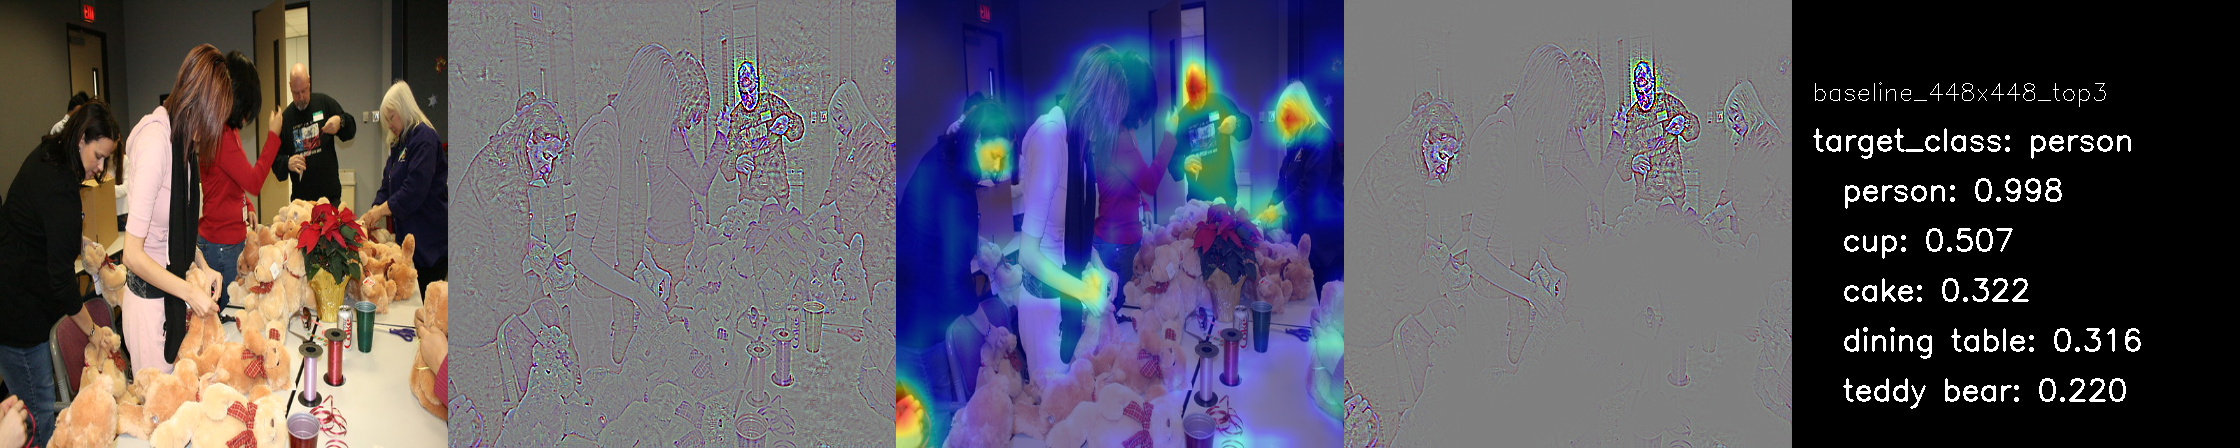

teddy_person.jpg


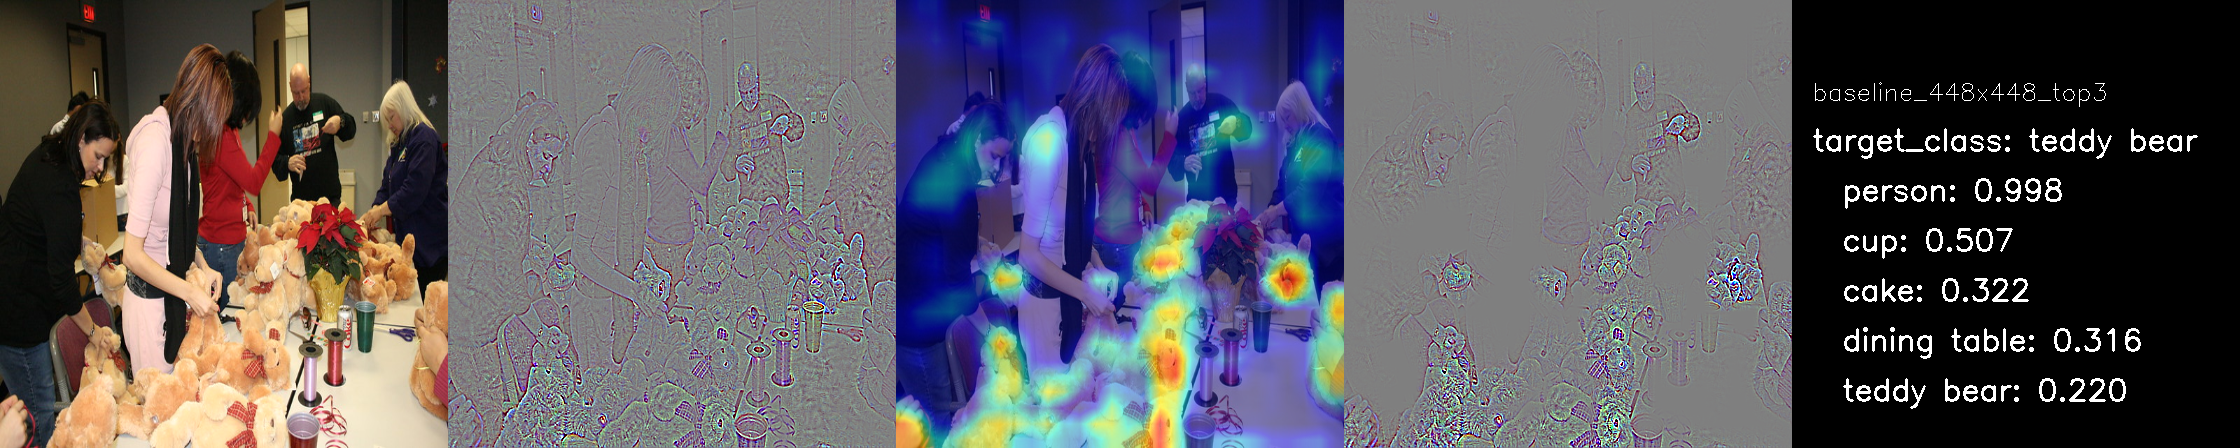

In [5]:
if __name__ == '__main__':
    path = "teddy_person.jpg"
    show_gradcam(path,target_class=None)
    show_gradcam(path,target_class="teddy bear")
